# Check the output of the ffcv dataloader

In [35]:
import numpy as np
from pathlib import Path

import torch as ch

from ffcv.pipeline.operation import Operation
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, Squeeze, NormalizeImage, \
    RandomHorizontalFlip, ToTorchImage
from ffcv.fields.rgb_image import CenterCropRGBImageDecoder
from ffcv.fields.basics import IntDecoder
from ffcv.fields import IntField, RGBImageField

from utils.utils import LARS, cosine_scheduler, learning_schedule
from utils.remote_storage import RemoteStorage

from torchvision import models
from utils.transforms import InvertTensorImageColors, InvertImageColorsFFCV

IMAGE_STATS = dict(
    imagenet_rgb=dict(
        mean=np.array([0.485, 0.456, 0.406]) * 255,
        std=np.array([0.229, 0.224, 0.225]) * 255
    ),
    imagenet_rgb_avg=dict(
        mean=np.array([0.449, 0.449, 0.449]) * 255,
        std=np.array([0.226, 0.226, 0.226]) * 255
    ),
    imagenet_rgb_avg_stdonly=dict(
        mean=np.array([0.0, 0.0, 0.0]) * 255,
        std=np.array([0.226, 0.226, 0.226]) * 255
    ),
    imagenet_line_stdonly=dict(
        mean=np.array([0.0, 0.0, 0.0]) * 255,
        std=np.array([0.181, 0.181, 0.181]) * 255
    ),
    no_op=dict(
        mean=np.array([0.0, 0.0, 0.0]) * 255,
        std=np.array([1.0, 1.0, 1.0]) * 255
    )
)
DEFAULT_CROP_RATIO = 224/256

In [94]:
def create_train_loader(train_dataset, num_workers, batch_size, 
                        image_stats_rgb, image_stats_line,
                        distributed=0, in_memory=0, gpu=0):
        this_device = f'cuda:{gpu}'
        train_path = Path(train_dataset)
        assert train_path.is_file()
        
        is_line_drawing_dataset = '_style_' in train_dataset
        
        if is_line_drawing_dataset:
            mean = IMAGE_STATS[image_stats_line]['mean']
            std = IMAGE_STATS[image_stats_line]['std']
        else:
            mean = IMAGE_STATS[image_stats_rgb]['mean']
            std = IMAGE_STATS[image_stats_rgb]['std']
        
        # image pipeline
        decoder = ffcv.transforms.RandomResizedCrop((224, 224))
        image_pipeline: List[Operation] = [
            decoder,
            RandomHorizontalFlip(),
            ffcv.transforms.RandomGrayscale(0.2),
            ToTensor(),
            ToDevice(ch.device(this_device), non_blocking=True),
            ToTorchImage(),
        ]
        
        if is_line_drawing_dataset:
            image_pipeline += [InvertImageColorsFFCV()]
            
        image_pipeline += [NormalizeImage(mean, std, np.float16)]
        
        label_pipeline: List[Operation] = [
            IntDecoder(),
            ToTensor(),
            Squeeze(),
            ToDevice(ch.device(this_device), non_blocking=True)
        ]

        pipelines={
            'image': image_pipeline,
            'label': label_pipeline,
            'index': None,    # drop index
            'rel_path': None, # drop rel_path
        }

        order = OrderOption.RANDOM if distributed else OrderOption.QUASI_RANDOM
        custom_field_mapper={}

        # Create data loader
        loader = ffcv.Loader(train_dataset,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        order=order,
                        os_cache=in_memory,
                        drop_last=True,
                        pipelines=pipelines,
                        distributed=distributed,
                        custom_fields={
                            'image': RGBImageField,
                            'label': IntField,
                        },
                        custom_field_mapper=custom_field_mapper)

        return loader

In [95]:
def create_val_loader(val_dataset, num_workers, batch_size, 
                      image_stats_rgb, image_stats_line,
                      resolution=224, distributed=0, gpu=0):
        this_device = f'cuda:{gpu}'
        val_path = Path(val_dataset)
        assert val_path.is_file()
        
        is_line_drawing_dataset = '_style_' in val_dataset
        
        if is_line_drawing_dataset:
            mean = IMAGE_STATS[image_stats_line]['mean']
            std = IMAGE_STATS[image_stats_line]['std']
        else:
            mean = IMAGE_STATS[image_stats_rgb]['mean']
            std = IMAGE_STATS[image_stats_rgb]['std']
        
        res_tuple = (resolution, resolution)
        cropper = CenterCropRGBImageDecoder(res_tuple, ratio=DEFAULT_CROP_RATIO)
        image_pipeline = [
            cropper,
            ToTensor(),
            ToDevice(ch.device(this_device), non_blocking=True),
            ToTorchImage(),
        ]
        
        if invert_colors:
            image_pipeline += [InvertImageColorsFFCV()]
            
        image_pipeline += [NormalizeImage(mean, std, np.float16)]
        
        label_pipeline = [
            IntDecoder(),
            ToTensor(),
            Squeeze(),
            ToDevice(ch.device(this_device),
            non_blocking=True)
        ]

        order = OrderOption.SEQUENTIAL

        loader = Loader(val_dataset,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        order=order,
                        drop_last=False,
                        pipelines={
                            'image': image_pipeline,
                            'label': label_pipeline,
                            'index': None,    # drop index
                            'rel_path': None, # drop rel_path
                        },
                        custom_fields={
                            'image': RGBImageField,
                            'label': IntField,
                        },
                        distributed=distributed)
        return loader

In [96]:
import os

train_dataset = os.path.join(os.environ['SHARED_DATA_DIR'],
                             'imagenet1k-line-ffcv',
                             'imagenet1k-anime_style_train_jpg_q100_s256_lmax512_crop-2b7bdbda.ffcv',
                            )
train_dataset                             

'/n/alvarez_lab_tier1/Users/alvarez/datasets/imagenet1k-line-ffcv/imagenet1k-anime_style_train_jpg_q100_s256_lmax512_crop-2b7bdbda.ffcv'

In [104]:
val_dataset = os.path.join(os.environ['SHARED_DATA_DIR'],
                             'imagenet1k-line-ffcv',
                             'imagenet1k-anime_style_val_jpg_q100_s256_lmax512_crop-872c1585.ffcv',
                            )

# val_dataset = os.path.join(os.environ['SHARED_DATA_DIR'],
#                              'imagenet1k-ffcv',
#                              'imagenet1k_train_jpg_q100_s256_lmax512_crop.ffcv',
#                             )

val_dataset                             

'/n/alvarez_lab_tier1/Users/alvarez/datasets/imagenet1k-line-ffcv/imagenet1k-anime_style_val_jpg_q100_s256_lmax512_crop-872c1585.ffcv'

In [109]:
image_stats = 'imagenet_line_stdonly'
val_loader = create_val_loader(val_dataset, num_workers=12, batch_size=256, 
                               image_stats=image_stats)

val_loader

invert_colors? True


In [110]:
imgs,labels = next(iter(val_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.) tensor(4.9609)


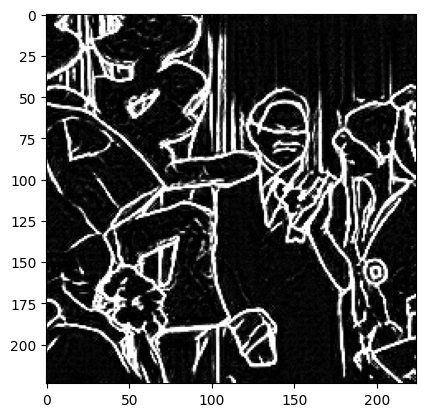

In [116]:
import matplotlib.pyplot as plt

img = imgs[0]
# img = img - img.min()
# img = img / img.max()
# print(img.shape)
min_val = img.moveaxis(0,2).float().cpu().min()
max_val = img.moveaxis(0,2).float().cpu().max()
print(min_val, max_val)
plt.imshow(img.moveaxis(0,2).float().cpu().numpy());

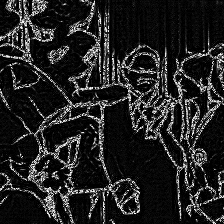

In [112]:
from torchvision import transforms as tv_transforms

to_pil = tv_transforms.ToPILImage()
to_pil(img)